In [1]:
from jet_ML_tools import *
from data_import import data_import

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

Using Theano backend.
Using gpu device 0: GeForce GTX 660M (CNMeM is enabled with initial size: 15.0% of memory, cuDNN 5105)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [193]:
# specify the file inputs
n_files = 2
n_ev_per_file = 10000
s_range = range(1,1+n_files)

# read in the data
nevents = n_files * n_ev_per_file
#data = data_import(data_type='jetimage', seed_range=s_range, path = '/Users/pkomiske/Documents/Data/images/')
X_train = data_import(data_type='jetimage', seed_range=s_range, path = '/Users/pkomiske/Documents/Data/images/')
Y_train = make_labels(nevents, nevents)

X_val = data_import(data_type='jetimage', seed_range = [6], path = '/Users/pkomiske/Documents/Data/images/')
Y_val = make_labels(n_ev_per_file, n_ev_per_file)

# read in the labels and split the data by quark and gluon
#labels = make_labels(nevents, nevents)

In [194]:
# Adapted from: github.com/derylucio/weaksupervision

from keras.optimizers import Adam

# Weak supervision loss function
def weak_loss_function(ytrue, ypred):
    return K.square((K.sum(ypred[:,1]) - K.sum(ytrue[:,1])) / ytrue.shape[0])

# Generates batches for training with keras
def weak_data_generator(samples, outputs, batch_size):
    n_batches = int(samples[0].shape[0]/batch_size)
    while True:
        for i in range(n_batches):
            for sample, output in zip(samples, outputs):
                yield sample[i*batch_size:(i+1)*batch_size], output[i*batch_size:(i+1)*batch_size]                
                
def make_bunches(X, Y, min = .25, max = .75, N = 10, rand = True, weak = True):
    
    # handle different encodings of Y
    n_gluons = np.sum(Y[:,0])
    n_quarks = np.sum(Y[:,1])
    assert n_gluons == n_quarks, 'Haven\'t implemented this yet'
        
    total = n_gluons + n_quarks
    
    # let bunch_frac be the number of quarks
    if rand:
        # handle only even N
        assert N/2 == int(N/2)
        bunch_fracs = np.random.random(int(N/2))*(max - min) + min
        bunch_fracs = np.concatenate((bunch_fracs, 1 - bunch_fracs))
    else:
        bunch_fracs = np.linspace(min, max, N)
    np.random.shuffle(bunch_fracs)
    
    n_gluons_by_bunch = [int(total/N * (1 - frac)) for frac in bunch_fracs[:-1]]
    n_quarks_by_bunch = [int(total/N * frac) for frac in bunch_fracs[:-1]]
    n_gluons_by_bunch.append(int(n_gluons - np.sum(n_gluons_by_bunch)))
    n_quarks_by_bunch.append(int(n_quarks - np.sum(n_quarks_by_bunch)))

    X_gluon = X[Y[:,0]==1]
    X_quark = X[Y[:,1]==1]
    
    X_out, Y_out = [], []
    gi = 0
    qi = 0
    for ng, nq, frac in zip(n_gluons_by_bunch, n_quarks_by_bunch, bunch_fracs):
        perm = np.random.permutation(np.arange(ng+nq)).astype(int)
        X_out.append(np.concatenate((X_gluon[gi:gi+ng], X_quark[qi:qi+nq]))[perm])
        if weak:
            fracs = frac * np.ones((ng+nq, 2))
            fracs[:,0] = 1 - frac
            Y_out.append(fracs)
        else:
            Y_out.append(to_categorical(np.concatenate((np.zeros(ng), np.ones(nq)))[perm], 2))
        gi += ng
        qi += nq
        
    return X_out, Y_out

In [ ]:
learning_rate = 0.001
weak = True
hps = {'batch_size': 100, 'img_size': 33,'nb_epoch': 10, 'nb_conv': [8,4,4], 'nb_filters': [64, 64, 64],
       'nb_neurons': 128, 'nb_pool': [2, 2, 2], 'dropout': [.25, .5, .5, .5],
       'nb_channels': 1, 'patience': 3, 'out_dim' : 2, 'N': 2}

listX_train, listX_val = [], []
listf_train, listf_val = [], []

# split the data and fractions into training and validation sets
while True:
    try:
        #X_train, Y_train, X_val, Y_val = data_split(data, labels, val_frac = .1, test_frac = 0)
        X_bunches, Y_bunches = make_bunches(X_train, 
                                            Y_train, 
                                            N = hps['N'], 
                                            rand = False, 
                                            weak = weak, 
                                            min = .1, 
                                            max = .9)
    except AssertionError:
        pass
    else:
        break

CNN_model = conv_net_construct(hps, compiled = False)
earlystopper = EarlyStopping(monitor="val_loss", patience= hps['patience'])
batch_size = hps['batch_size']
if weak:
    CNN_model.compile(loss=weak_loss_function, optimizer=Adam(lr=learning_rate), metrics = ['accuracy']) 
else:
    CNN_model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics = ['accuracy'])

#CNN_model.summary()
history = CNN_model.fit_generator(generator = weak_data_generator(X_bunches, Y_bunches, hps['batch_size']), 
                        samples_per_epoch = int(X_bunches[0].shape[0]/batch_size)*batch_size*hps['N'],
                        nb_epoch = hps['nb_epoch'], 
                        validation_data = (X_val, Y_val), 
                        callbacks = [earlystopper])

Epoch 1/10
39800/39800 [==============================] - 25s - loss: 0.0942 - acc: 0.6262 - val_loss: 0.0829 - val_acc: 0.7170
Epoch 2/10
39800/39800 [==============================] - 25s - loss: 0.0586 - acc: 0.6669 - val_loss: 0.0811 - val_acc: 0.7204
Epoch 3/10
26300/39800 [==================>...........] - ETA: 7s - loss: 0.0560 - acc: 0.6701

In [170]:
results = np.zeros((7,8))
for i,batch_size in enumerate([2,4,8,16,32,64,128]):
    for j,N in enumerate([1,2,3,4,5,10,20,50]):

        learning_rate = 0.001
        weak = True
        hps = {'batch_size': batch_size, 'img_size': 33,'nb_epoch': 1, 'nb_conv': [8,4,4], 'nb_filters': [64, 64, 64],
               'nb_neurons': 128, 'nb_pool': [2, 2, 2], 'dropout': [.25, .5, .5, .5],
               'nb_channels': 1, 'patience': 3, 'out_dim' : 2, 'N': N}

        listX_train, listX_val = [], []
        listf_train, listf_val = [], []

        # split the data and fractions into training and validation sets
        while True:
            try:
                #X_train, Y_train, X_val, Y_val = data_split(data, labels, val_frac = .1, test_frac = 0)
                X_bunches, Y_bunches = make_bunches(X_train, Y_train, N = hps['N'], rand = False)
            except AssertionError:
                pass
            else:
                break

        CNN_model = conv_net_construct(hps, compiled = False)
        earlystopper = EarlyStopping(monitor="val_loss", patience= hps['patience'])
        batch_size = hps['batch_size']
        if weak:
            CNN_model.compile(loss=weak_loss_function, optimizer=Adam(lr=learning_rate), metrics = ['accuracy']) 
        else:
            CNN_model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate), metrics = ['accuracy'])

        #CNN_model.summary()
        history = CNN_model.fit_generator(generator = weak_data_generator(X_bunches, Y_bunches, hps['batch_size']), 
                                samples_per_epoch = int(X_bunches[0].shape[0]/batch_size)*batch_size*hps['N'],
                                nb_epoch = hps['nb_epoch'], 
                                validation_data = (X_val, Y_val), 
                                callbacks = [earlystopper])
        print('RESULT: batch_size = {}, N = {}, val_acc = {}'.format(batch_size, N, history.history['val_acc'][0]))
        results[i,j] = history.history['val_acc'][0]

Epoch 1/1
 7122/36000 [====>.........................] - ETA: 77s - loss: 0.6877 - acc: 0.9955

KeyboardInterrupt: 

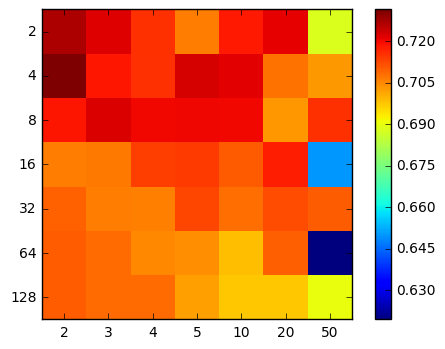

In [141]:
bs = [2,4,8,16,32,64,128]
Ns = [1,2,3,4,5,10,20,50][1:]
plt.imshow(results[:,1:], interpolation='none')
plt.xticks(np.arange(len(Ns)), Ns)
plt.yticks(np.arange(len(bs)), bs)
plt.colorbar()
plt.show()

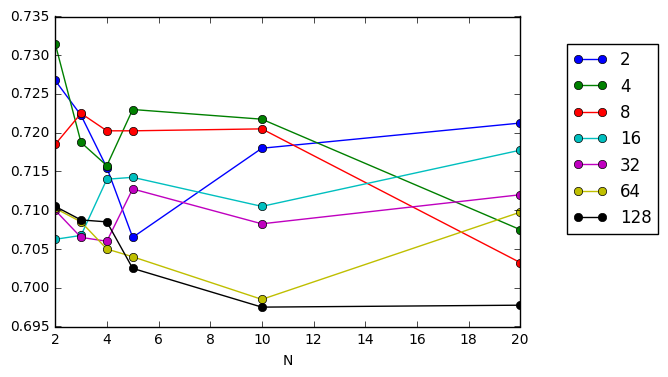

In [160]:
for i,b in enumerate(bs):
    plt.plot(Ns[:-1], results[i,1:-1], '-o', label = str(b))
plt.xlabel('N')
plt.legend(loc = (1.1,.3))
plt.show()

In [175]:
qe_s, ge_s = ROC_from_model(CNN_model, X_val, Y_val)

In [184]:
print(gr_at_50_qe(qe_s,ge_s))
print(gr_at_50_qe(qe_w,ge_w))

0.077
0.0805


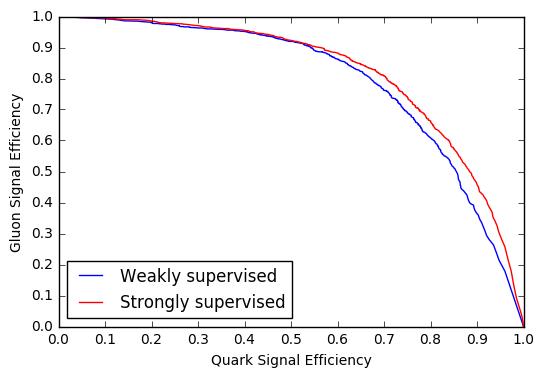

In [182]:
plot_ROC(qe_w, ge_w, show = False, label = 'Weakly supervised')
plot_ROC(qe_s, ge_s, color = 'red', show = False, label = 'Strongly supervised')
plt.title('')
plt.legend(loc = 'lower left')
plt.savefig('../plots/weak-strong-comparison.pdf', bbox_inches = 'tight')
plt.show()